<a href="https://colab.research.google.com/github/kpe/bert-for-tf2/blob/master/examples/tpu_movie_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

This colab notebook demonstrates how to fine-tune a 
BERT based sentiment classifier on the IMDB Movie Reviews 
dataset using a freely provided colab TPU.

We'll be using the TensorFlow Keras API implementation of BERT from [kpe/bert-for-tf2](https://github.com/kpe/bert-for-tf2)
and the pre-trained BERT weights from [google-research/bert](https://github.com/google-research/bert).
Instead of fine-tunning all of BERT weights, we'll make use of the [adapter-BERT](https://arxiv.org/abs/1902.00751) architecture to fine-tune only a fraction of the weighs, while keeping the original BERT weights frozen.


Currently the combination of a colab TPU and Keras does not work with the Beta Tensorflow 2.0 or the eager execution in TensorFlow 1.14, so we have to stick to non-eager execution and TF 1.14. 

The main steps towards training a Keras model on a TPU in colab would be:
 - **Google Storage Bucket** - TPUs currently need write access to a Google Storage Bucket for loading training data or weights and storing model checkpoints.
 - **GCP Authentication** - once you hava a storage bucket, giving colab the authorization to use it, is realy easy.
 - **pre-trained BERT** - we have to also copy the pre-trained BERT weights to our storage bucket (because loading the pre-trained checkpoint needs list permissions)
 - **TFRecord** - to fully utilize the TPU power, we need to feed the training data in the most efficient way possible, for which we'd be using a TFRecordDataset by encoding our training examples into tfrecord files.
 - **TPU Training** - simlpy create a Keras model inside a `TPU Distribution Strategy` scope would then be enough for placing our model on the TPU ready for training.
 



# Storage Bucket Authentication

You need to setup a storage bucket in GCP for storing and loading model weights and feeding data into the TPUs.

In [0]:
import os
import tensorflow as tf

In [2]:
BUCKET = 'YOUR BUCKET NAME' #@param {type:"string"}

OUTPUT_DIR = 'OUTPUT PATH '#@param {type:"string"}

#@markdown Whether or not to clear/delete the directory and create a new one
DO_DELETE = False #@param {type:"boolean"}


OUTPUT_DIR = 'gs://{}/colab/{}'.format(BUCKET, OUTPUT_DIR)
from google.colab import auth
auth.authenticate_user()

if DO_DELETE:
  try:
    tf.gfile.DeleteRecursively(OUTPUT_DIR)
  except:
    # Doesn't matter if the directory didn't exist
    pass
tf.gfile.MakeDirs(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))

***** Model output directory: gs://kpe/colab/movie_reviews *****


# Prerequisites

In [0]:
!pip install tqdm >> /dev/null

#!pip install -q tensorflow==2.0.0-beta1 # TPU with Keras on TF 2.0 seems to have problems, so we don't use it yet

In [0]:
import os
import math
import datetime


from tqdm import tqdm

import numpy as np

import tensorflow as tf
from tensorflow import keras

In [5]:
tf.__version__

'1.14.0'

To enable the TPU - it seems to be neccessary to do this `tf.config.experimental` call in the beginning of the session:

In [6]:
USE_TPU=True
try:
  # This address identifies the TPU we'll use when configuring TensorFlow.
  TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  tf.config.experimental_connect_to_host(TPU_WORKER)
except Exception as ex:
  print(ex)
  USE_TPU=False

print("        USE_TPU:", USE_TPU)
print("Eager Execution:", tf.executing_eagerly())

assert not tf.executing_eagerly(), "Eager execution on TPUs have issues currently"

        USE_TPU: True
Eager Execution: False


So lets also pip install the [bert-for-tf2](https://github.com/kpe/bert-for-tf2) python package containing the Keras implementation of BERT.

In [0]:
!pip install --upgrade bert-for-tf2 params-flow >> /dev/null

In [0]:
import params_flow as pf

from bert import BertModelLayer
from bert import FullTokenizer
from bert import load_stock_weights, params_from_pretrained_ckpt


# The BERT Pre-Trained

The original pre-trained BERT weights are available in a Google Storage Bucket at `gs://bert_models/`, but without list permission which are needed by the TensorFlow APIs used for loading the weights from the pre-trained checkpoint, so we have to copy the pre-trained model to our own bucket:

In [9]:
bert_ckpt_dir    = "gs://bert_models/2018_10_18/uncased_L-12_H-768_A-12"
bert_ckpt_file   = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")
bert_model_name  = os.path.basename(os.path.dirname(bert_ckpt_file))

bert_ckpt_files = ["bert_config.json",
                   "bert_model.ckpt.data-00000-of-00001",
                   "bert_model.ckpt.index",
                   "bert_model.ckpt.meta",
                   "vocab.txt"]

gs_bert_ckpt_dir = os.path.join(OUTPUT_DIR, "bert_models", bert_model_name)
if not tf.io.gfile.exists(gs_bert_ckpt_dir):
  cmd = " ".join([os.path.join(bert_ckpt_dir, bert_file)
                   for bert_file in bert_ckpt_files])
  cmd = "gsutil -m cp {} {}".format(cmd, gs_bert_ckpt_dir)
  !$cmd

!gsutil ls $gs_bert_ckpt_dir

gs://kpe/colab/movie_reviews/bert_models/uncased_L-12_H-768_A-12/bert_config.json
gs://kpe/colab/movie_reviews/bert_models/uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001
gs://kpe/colab/movie_reviews/bert_models/uncased_L-12_H-768_A-12/bert_model.ckpt.index
gs://kpe/colab/movie_reviews/bert_models/uncased_L-12_H-768_A-12/bert_model.ckpt.meta
gs://kpe/colab/movie_reviews/bert_models/uncased_L-12_H-768_A-12/vocab.txt


In [10]:
bert_ckpt_dir    = gs_bert_ckpt_dir
bert_ckpt_file   = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

print("Using BERT checkpoint from:", bert_ckpt_dir)

Using BERT checkpoint from: gs://kpe/colab/movie_reviews/bert_models/uncased_L-12_H-768_A-12


# The IMDB Movie Review Dataset

Lets use [kpe/params-flow](https://github.com/kpe/params-flow) to lazy download and upack the IMDB Movie Review Dataset (`params_flow` has been already pip installed as a [kpe/bert-for-tf2](https://github.com/kpe/params-flow) dependency).

In [11]:
fetched_file = pf.utils.fetch_url("http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", fetch_dir=".data")
unpack_dir   = pf.utils.unpack_archive(fetched_file)
data_dir     = os.path.join(unpack_dir, "aclImdb")

!ls -la $data_dir

Already  fetched:  aclImdb_v1.tar.gz
already unpacked at: .data/aclImdb_v1
total 1732
drwxr-xr-x 4 7297 1000   4096 Jun 26  2011 .
drwxr-xr-x 3 root root   4096 Aug 13 07:24 ..
-rw-r--r-- 1 7297 1000 903029 Jun 11  2011 imdbEr.txt
-rw-r--r-- 1 7297 1000 845980 Apr 12  2011 imdb.vocab
-rw-r--r-- 1 7297 1000   4037 Jun 26  2011 README
drwxr-xr-x 4 7297 1000   4096 Apr 12  2011 test
drwxr-xr-x 5 7297 1000   4096 Jun 26  2011 train


# The TFRecords Conversion

We would now convert the raw dataset into TFRecord files, for which we need the following functions:
 - load every dataset file
 - preprocess each sample by removing the `</ br>` markup
 - encode the label to an integer (i.e. 0 or 1) and the text by tokenizing with the BERT tokenizer and taking the token integer ids (a vocab file is provided with the pre-trained model)
 - serialize the so encoded examples to a tfrecord file

In [0]:
from functools import partial
from glob import glob
from multiprocessing import Pool


def load_sample(path):
    """Loads an IMDB Movie Reviews data sample from a file."""
    label   = path.split('/')[-2]
    with open(path, "r") as f:
        content = f.read()
    return content, label
    
def preprocess_sample(content, label):
    content = content.replace("<br />", " ")
    return content, label
    
def encode_sample(content, label, tokenizer):
    content = tokenizer.tokenize(content)
    content = tokenizer.convert_tokens_to_ids(content)
    label = int(label == "pos")
    return content, label

def serialize_example(token_ids, label):
    feature = {
        "token_ids": tf.train.Feature(int64_list=tf.train.Int64List(value=token_ids)),
        "label":     tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))
    }
    proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return proto.SerializeToString()

def to_tfrecord(file_path, tokenizer):
    sample = load_sample(file_path)
    sample = preprocess_sample(*sample)
    sample = encode_sample(*sample, tokenizer=tokenizer)
    sample = serialize_example(*sample)
    return sample

def convert_to_tfrecord_file(file_name, ds_dir, serializer_fn):
    with tf.python_io.TFRecordWriter(file_name) as writer:    
        all_files = glob(os.path.join(ds_dir, "pos/*"))
        all_files += glob(os.path.join(ds_dir, "neg/*"))
        with Pool() as pool:
            protos = pool.imap_unordered(serializer_fn, all_files)
            for proto in tqdm(protos, total=len(all_files)):
                writer.write(proto)

We would also store the `tfrecords` in out bucket:

In [0]:
train_tfrecord_file = os.path.join(OUTPUT_DIR, "data", "train.tfrecord")
test_tfrecord_file  = os.path.join(OUTPUT_DIR, "data", "test.tfrecord")

Now we can instantiate the BERT tokenizer and do the TFRecord conversion:

In [0]:
tokenizer = FullTokenizer(os.path.join(bert_ckpt_dir, "vocab.txt"))

def serialize_to_tfrecord(ds_file):
    return to_tfrecord(ds_file, tokenizer)
        
if not all([tf.io.gfile.exists(train_tfrecord_file),
            tf.io.gfile.exists(test_tfrecord_file)]):
  print("Preparing the [train, test].tfrecord files...")
  
  convert_to_tfrecord_file(train_tfrecord_file, 
                           os.path.join(data_dir, "train"),
                           serialize_to_tfrecord)
  convert_to_tfrecord_file(test_tfrecord_file, 
                           os.path.join(data_dir, "test"),
                           serialize_to_tfrecord)

For reading the tfrecord files we would use a `TFRecordDataset`. For batching the data we must make sure all sequences have the same lenght, so we must also trim and pad them:

In [0]:
def tfrecord_to_dataset(filenames):
  ds = tf.data.TFRecordDataset(filenames)
  feature_description = {
      "token_ids":  tf.io.VarLenFeature(tf.int64),
      "label":      tf.io.FixedLenFeature([], tf.int64, default_value=-1)
  }

  def parse_proto(proto):
    example = tf.io.parse_single_example(proto, feature_description)
    token_ids, label = example["token_ids"], example["label"]
    token_ids = tf.sparse_tensor_to_dense(token_ids)
    return token_ids, label

  return ds.map(parse_proto)


def create_pad_example_fn(pad_len, padding=0, trim_beginning=True):
  def pad_example(x, label):
    x = x[-pad_len:] if trim_beginning else x[:-pad_len]
    x = tf.pad(x, [[0, pad_len - tf.shape(x)[-1]]], constant_values=padding)
    #x = tf.concat([x, padding*tf.ones(pad_len - tf.shape(x)[-1], dtype=x.dtype)], axis=-1)
    return  tf.reshape(x, (max_seq_len,)), tf.reshape(label, ())
  return pad_example    


In [0]:
train_tfrecord_file = os.path.join(OUTPUT_DIR, "data", "train.tfrecord")
test_tfrecord_file  = os.path.join(OUTPUT_DIR, "data", "test.tfrecord")

Because BERT can handle up to 512 tokens, and because BERT computational and memory requirements scale quadratically with the input sequence length, we will have to trim the sequences to a shorter size, but let's first check the sequence length distribution, and how many examples would be affected, if we trim all sequences to 512 tokens:

train drop count: 3290 of 25000 - 13.16%
 test drop count: 3057 of 25000 - 12.23%


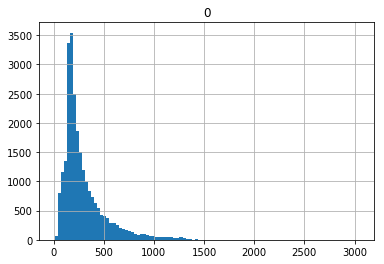

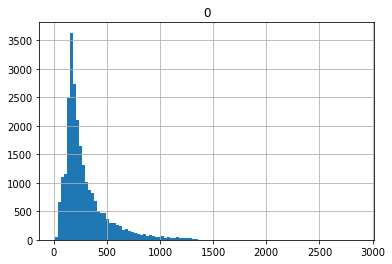

In [17]:
import pandas as pd

train_lens = []
test_lens  = []

count = 0

def get_sequence_lengths(tfrecord_file):
  res = []

  def sample_seq_len(tok_id, lab):
    return tf.shape(tok_id)[0]
  
  ds = tfrecord_to_dataset([tfrecord_file]).map(sample_seq_len).batch(128)
  if tf.executing_eagerly():
    for seq_len in ds:
      res.extend(res)
  else:
    it = tf.compat.v1.data.make_one_shot_iterator(ds)
    seq_lens = it.get_next()
    with tf.Session() as sess:
      try:
        while True:
          res.extend(list(sess.run(seq_lens)))
      except Exception as ex:
        pass
  return res


def show_drop_count(lens, max_seq_len = 512, name="ds"):
    df = pd.DataFrame(lens)
    df.hist(bins=100)
    drop_count = df[df[0]>max_seq_len].shape[0]
    print("{:>5s} drop count: {} of {} - {:5.2f}%".format(name, drop_count, len(lens), 100*drop_count/len(lens)))

train_lens = get_sequence_lengths(train_tfrecord_file)
test_lens = get_sequence_lengths(test_tfrecord_file)

    
show_drop_count(train_lens, name="train")
show_drop_count(test_lens, name="test")

# The Model (finally)


Now let's create a classification model using [adapter-BERT](https//arxiv.org/abs/1902.00751), which is a clever way 
of reducing the trainable parameter count, by freezing the original BERT weights, 
and adapting the internal activations with two FFN bottlenecks (i.e. `adapter_size` bellow) in every BERT layer. 

For sequence classification BERT proposes a classifier acting on the `[CLS]` output alone. Such a classifier overfits easily and is difficult to regularize. 
As an alternative we'll be using max pooling on the complete output sequence.  For regularization we rely entirely upon layer normalization and the selection of small sizes for `adapter_size` and the classifier layers (and one cycle learning policy with a big learning rate).

(The intuition being, that the `[CLS]` output during pre-training is never trained to capture global sequence representations, and would therefore need more adaption for finding the optimal `[CLS]` representation during fine-tunning, while at the same time this would overfit all the other activations.)


In [0]:
def create_model(max_seq_len, 
                 adapter_size=64,
                 batch_size=None,
                 init_ckpt_file=None,
                 init_bert_ckpt_file=bert_ckpt_file,
                ):
  """Creates a classification model.
  :param adapter_size: adapter bottleneck size - arXiv:1902.00751
  """

  bert_params = params_from_pretrained_ckpt(os.path.dirname(init_bert_ckpt_file))
  
  # create the bert layer
  bert_params.adapter_size = adapter_size
  bert_params.adapter_init_scale = 1e-5
  l_bert = BertModelLayer.from_params(bert_params, name="bert")

  max_pooling = True
  if max_pooling:
    model = keras.models.Sequential([
        keras.layers.InputLayer(input_shape=(max_seq_len,),
                                batch_size=batch_size,
                                dtype="int32", name="input_ids"),
        l_bert,

        #keras.layers.TimeDistributed(keras.layers.Dropout(0.1)),
        keras.layers.TimeDistributed(keras.layers.Dense(bert_params.hidden_size//32)),
        keras.layers.TimeDistributed(keras.layers.LayerNormalization()),
        keras.layers.TimeDistributed(keras.layers.Activation("tanh")),

        pf.Concat([
          keras.layers.Lambda(lambda x: tf.math.reduce_max(x, axis=1)),  # GlobalMaxPooling1D   
          keras.layers.GlobalAveragePooling1D()
        ]),

        #keras.layers.Dropout(0.5),
        keras.layers.Dense(units=bert_params.hidden_size//16),
        keras.layers.LayerNormalization(),
        keras.layers.Activation("tanh"),

        keras.layers.Dense(units=2)
    ])
  else:
    model = keras.models.Sequential([
        keras.layers.InputLayer(input_shape=(max_seq_len,),
                                batch_size=batch_size,
                                dtype="int32", name="input_ids"),
        l_bert,
        keras.layers.Lambda(lambda seq: seq[:, 0, :]),
        keras.layers.Dense(units=bert_params.hidden_size),
        keras.layers.Activation("tanh"),
        keras.layers.Dense(units=2)      
    ])
  
  model.build(input_shape=(batch_size, max_seq_len))
  
  # freeze non-adapter-BERT layers for the case adapter_size is set
  l_bert.apply_adapter_freeze()
  l_bert.embeddings_layer.trainable=False # True for unfreezing emb LayerNorms 
  
  model.compile(optimizer=keras.optimizers.Adam(),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")])

  # load the pre-trained model weights (once the input_shape is known)
  if init_ckpt_file:
    print("Loading model weights from:", init_ckpt_file)
    model.load_weights(init_ckpt_file)
  elif init_bert_ckpt_file:
    print("Loading pre-trained BERT layer from:", init_bert_ckpt_file)
    load_stock_weights(l_bert, init_bert_ckpt_file)

      
  return model


Bigger `max_seq_len` in a transformer model slows things quadratically, 
but being equipted with a free TPU, we'd go for the maximum sequence length, which in BERT is 512. We are chossing a realy small `adapter_size` and a rather huge learning rate, both of which are needed for regularization:

In [0]:
adapter_size = 4
max_seq_len  = 512
batch_size   = 128

So we are now finally ready to create our model. To make it run on a TPU, we need to wrap it's creation into a `TPUStrategy` scope:

In [20]:
assert not tf.executing_eagerly()

cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=TPU_WORKER)
tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
tpu_strategy = tf.distribute.experimental.TPUStrategy(cluster_resolver)

with tpu_strategy.scope():
  model = create_model(max_seq_len,
                       adapter_size, 
                       batch_size=batch_size,
                       init_bert_ckpt_file=bert_ckpt_file)

model.summary()

W0813 17:19:56.498743 139685937129344 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0813 17:19:56.634796 139685937129344 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Loading pre-trained BERT layer from: gs://kpe/colab/movie_reviews/bert_models/uncased_L-12_H-768_A-12/bert_model.ckpt
loader: No value for:[bert/encoder/layer_0/attention/output/adapter-down/kernel:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-down/kernel] in:[gs://kpe/colab/movie_reviews/bert_models/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert/encoder/layer_0/attention/output/adapter-down/bias:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-down/bias] in:[gs://kpe/colab/movie_reviews/bert_models/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert/encoder/layer_0/attention/output/adapter-up/kernel:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-up/kernel] in:[gs://kpe/colab/movie_reviews/bert_models/uncased_L-12_H-768_A-12/bert_model.ckpt]
loader: No value for:[bert/encoder/layer_0/attention/output/adapter-up/bias:0], i.e.:[bert/encoder/layer_0/attention/output/adapter-up/bias] in:[gs://kpe/colab/movie_reviews/bert_models

Here we use `drop_remainder=True` for making sure the `batch_size` is fixed:

In [21]:

ds = tfrecord_to_dataset([train_tfrecord_file])
ds = ds.map(create_pad_example_fn(pad_len=max_seq_len, padding=0))
ds = ds.cache()
ds = ds.shuffle(buffer_size=25000, seed=4711, reshuffle_each_iteration=True)
ds = ds.repeat()

ds = ds.batch(batch_size, drop_remainder=True)
train_ds = ds

W0813 17:21:37.432609 139685937129344 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/data/util/random_seed.py:58: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Once the model is trained, we'll store it in our bucket:

In [0]:
trained_ckpt_file = os.path.join(OUTPUT_DIR, 'checkpoints','trained','movie_reviews.ckpt')

and now lets proceed with the actual training on the TPU. We'll be using one cycle learning policy with a huge learning rate (which also works as a regularizer).

In [23]:
#%%time

if tf.io.gfile.exists(trained_ckpt_file):
  model.load_weights(trained_ckpt_file)
else:
  log_dir = os.path.join(OUTPUT_DIR, "log", datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

  total_epoch_count = 30
  lr_scheduler = pf.utils.create_one_cycle_lr_scheduler(max_learn_rate=3e-3,
                                                        end_learn_rate=1e-6,
                                                        warmup_epoch_count=25,
                                                        total_epoch_count=total_epoch_count)

  model.fit(train_ds,
            shuffle=True,
            epochs=total_epoch_count,
            steps_per_epoch=25000//batch_size,
            callbacks=[lr_scheduler,
                       keras.callbacks.EarlyStopping(patience=10, 
                                                     restore_best_weights=True, 
                                                     monitor='loss'), # TODO: validation on a TPU - how?
                       tensorboard_callback])
  model.save_weights(trained_ckpt_file, overwrite=True)

W0813 17:22:53.206323 139685937129344 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_distributed.py:411: Variable.load (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.



Epoch 00001: LearningRateScheduler reducing learning rate to 0.00012.
Epoch 1/30
  2/195 [..............................] - ETA: 23:05 - loss: 6.4600 - acc: 0.4492

W0813 17:23:07.561593 139685937129344 callbacks.py:257] Method (on_train_batch_end) is slow compared to the batch update (0.991821). Check your callbacks.


195/195 [==============================] - 90s 462ms/step - loss: 3.8401 - acc: 0.7565

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00024.
Epoch 2/30
195/195 [==============================] - 74s 381ms/step - loss: 2.1912 - acc: 0.8887

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00036.
Epoch 3/30
195/195 [==============================] - 75s 384ms/step - loss: 1.8930 - acc: 0.9077

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00048.
Epoch 4/30
195/195 [==============================] - 74s 381ms/step - loss: 1.7102 - acc: 0.9157

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0006000000000000001.
Epoch 5/30
195/195 [==============================] - 75s 385ms/step - loss: 1.5446 - acc: 0.9258

Epoch 00006: LearningRateScheduler reducing learning rate to 0.00072.
Epoch 6/30
195/195 [==============================] - 74s 379ms/step - loss: 1.5194 - acc: 0.9264

Epoch 00007: LearningRateScheduler reducing learning 

# Evaluation

To evaluate, we'd prepare a dataset:

In [0]:

def to_model_ds(tfrecord_file, batch_size=batch_size, drop_remainder=True):
  ds = tfrecord_to_dataset([tfrecord_file])
  ds = ds.map(create_pad_example_fn(pad_len=max_seq_len, padding=0))
  ds = ds.batch(batch_size, drop_remainder=drop_remainder)
  return ds

and call evaluate:

In [25]:

_, train_acc = model.evaluate(to_model_ds(train_tfrecord_file), steps=25000//batch_size)
_, test_acc = model.evaluate(to_model_ds(test_tfrecord_file), steps=25000//batch_size)

print("train acc", train_acc)
print(" test acc", test_acc)

195/195 [==============================] - 79s 407ms/step
train acc 0.9959936
 test acc 0.9409055


We could also create a new model, load the trained checkpoint and evaluate. 
Beware however that this would take ages on a CPU, so you might prefer running the lines below in a new GPU session:

In [26]:
%%time 

trained_ckpt_file = os.path.join(OUTPUT_DIR, 'checkpoints','trained','movie_reviews.ckpt')

model = create_model(max_seq_len, 
                     adapter_size=adapter_size,
                     init_ckpt_file=trained_ckpt_file)

#_, train_acc = model.evaluate(to_model_ds(train_tfrecord_file, drop_remainder=False))
#_, test_acc = model.evaluate(to_model_ds(test_tfrecord_file, drop_remainder=False))

print("train acc", train_acc)
print(" test acc", test_acc)

Loading model weights from: gs://kpe/colab/movie_reviews/checkpoints/trained/movie_reviews.ckpt
train acc 0.9959936
 test acc 0.9409055
CPU times: user 8.54 s, sys: 183 ms, total: 8.73 s
Wall time: 44.3 s
